## NN language models

Данные - корпус [ArXiv](http://arxiv.org/) статей с [kaggle](https://www.kaggle.com/neelshah18/arxivdataset/)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from random import sample
from tqdm import trange

%matplotlib inline

### Подготовка данных

In [ ]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2023-10-25 15:44:26--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-10-25 15:44:27--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2df292bd1db1be49bb4b05a73c.dl.dropboxusercontent.com/cd/0/get/CGRYzVLm7ziMjpw9BjNCZUUPmLeUdztzz-C7pY2CeJm8QMBXYnUEb0Dw-JLGoEDp-dS7abLb_7vr8d52e3bkB3Pd51G-kLmVtoWabJf8mKWovRSiCQ7WoeFWuLP5Qbfo3QU/file?dl=1# [following]
--2023-10-25 15:44:27--  https://uc2df292bd1db1be49bb4b05a73c.dl.dropboxusercontent.com/cd/0/get/CGRYzVLm7ziMjpw9BjNCZUUPmLeUdztzz-C7pY2CeJm8QMBXYnUEb0Dw-JLGoEDp-dS7abLb_7vr8d52e3bkB3Pd51G-k

,author,day,id,link,month,summary,tag,title,year
25708,"[{'name': 'Ksenia Konyushkova'}, {'name': 'Nik...",11,1511.03466v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,This paper introduces a novel approach to data...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",God(s) Know(s): Developmental and Cross-Cultur...,2015
20122,[{'name': 'Mark O. Riedl'}],22,1410.6142v3,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",10,Observing that the creation of certain types o...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",The Lovelace 2.0 Test of Artificial Creativity...,2014
19540,[{'name': 'Toby Walsh'}],3,0903.0465v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Symmetry is an important factor in solving man...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Breaking Value Symmetry,2009
22750,"[{'name': 'Matthew F. Dixon'}, {'name': 'Nicho...",27,1705.09851v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Deep learning applies hierarchical layers of h...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Deep Learning for Spatio-Temporal Modeling: Dy...,2017
19255,[{'name': 'Stephen I. Gallant'}],27,1304.2735v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"When creating an expert system, the most diffi...","[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Automated Generation of Connectionist Expert S...,2013


Нам понадобятся специальные токены:

* Begin Of Sequence  (__BOS__)
* End Of Sequence (__EOS__)


In [ ]:
BOS, EOS = ' ', '\n'

lines = data.apply(
    lambda row: (row['title'] + ' ; ' + row['summary'])[:512],
    axis=1,
).apply(lambda line: BOS + line.replace(EOS, ' ') + EOS).tolist()

In [ ]:
lines[:4]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Дальше построим **char-level vocabulary**

In [ ]:
tokens = list(set([char for word in lines for char in word]))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


Определим каждому символу свой числовой индекс


In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

token_to_id['o']

80

Соберем строки в матрицу `[batch_size, text_length]` и добавим паддинг до `max_len`

In [ ]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [ ]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Нейросетевая LM

Как и в случае модели на n-gram'ах мы снова хотим оценить вероятность текста как совместную вероятность токенов (символов)


$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Вместо того, чтобы считать статистики (counts) по корпусу, будем тренировать НС с параметрами $\theta$  для оценки условной вероятности:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$

Для начала возьмем архитектуру с фиксированным окном:

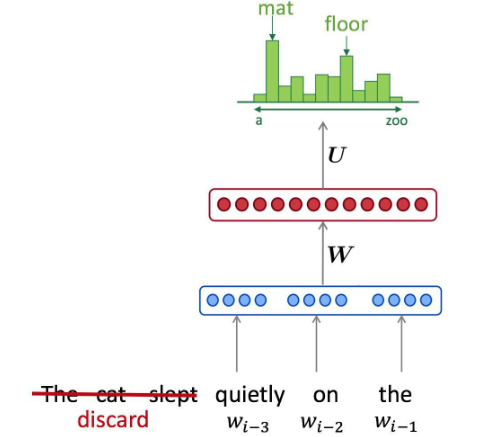


#### CNN для текстов - recap

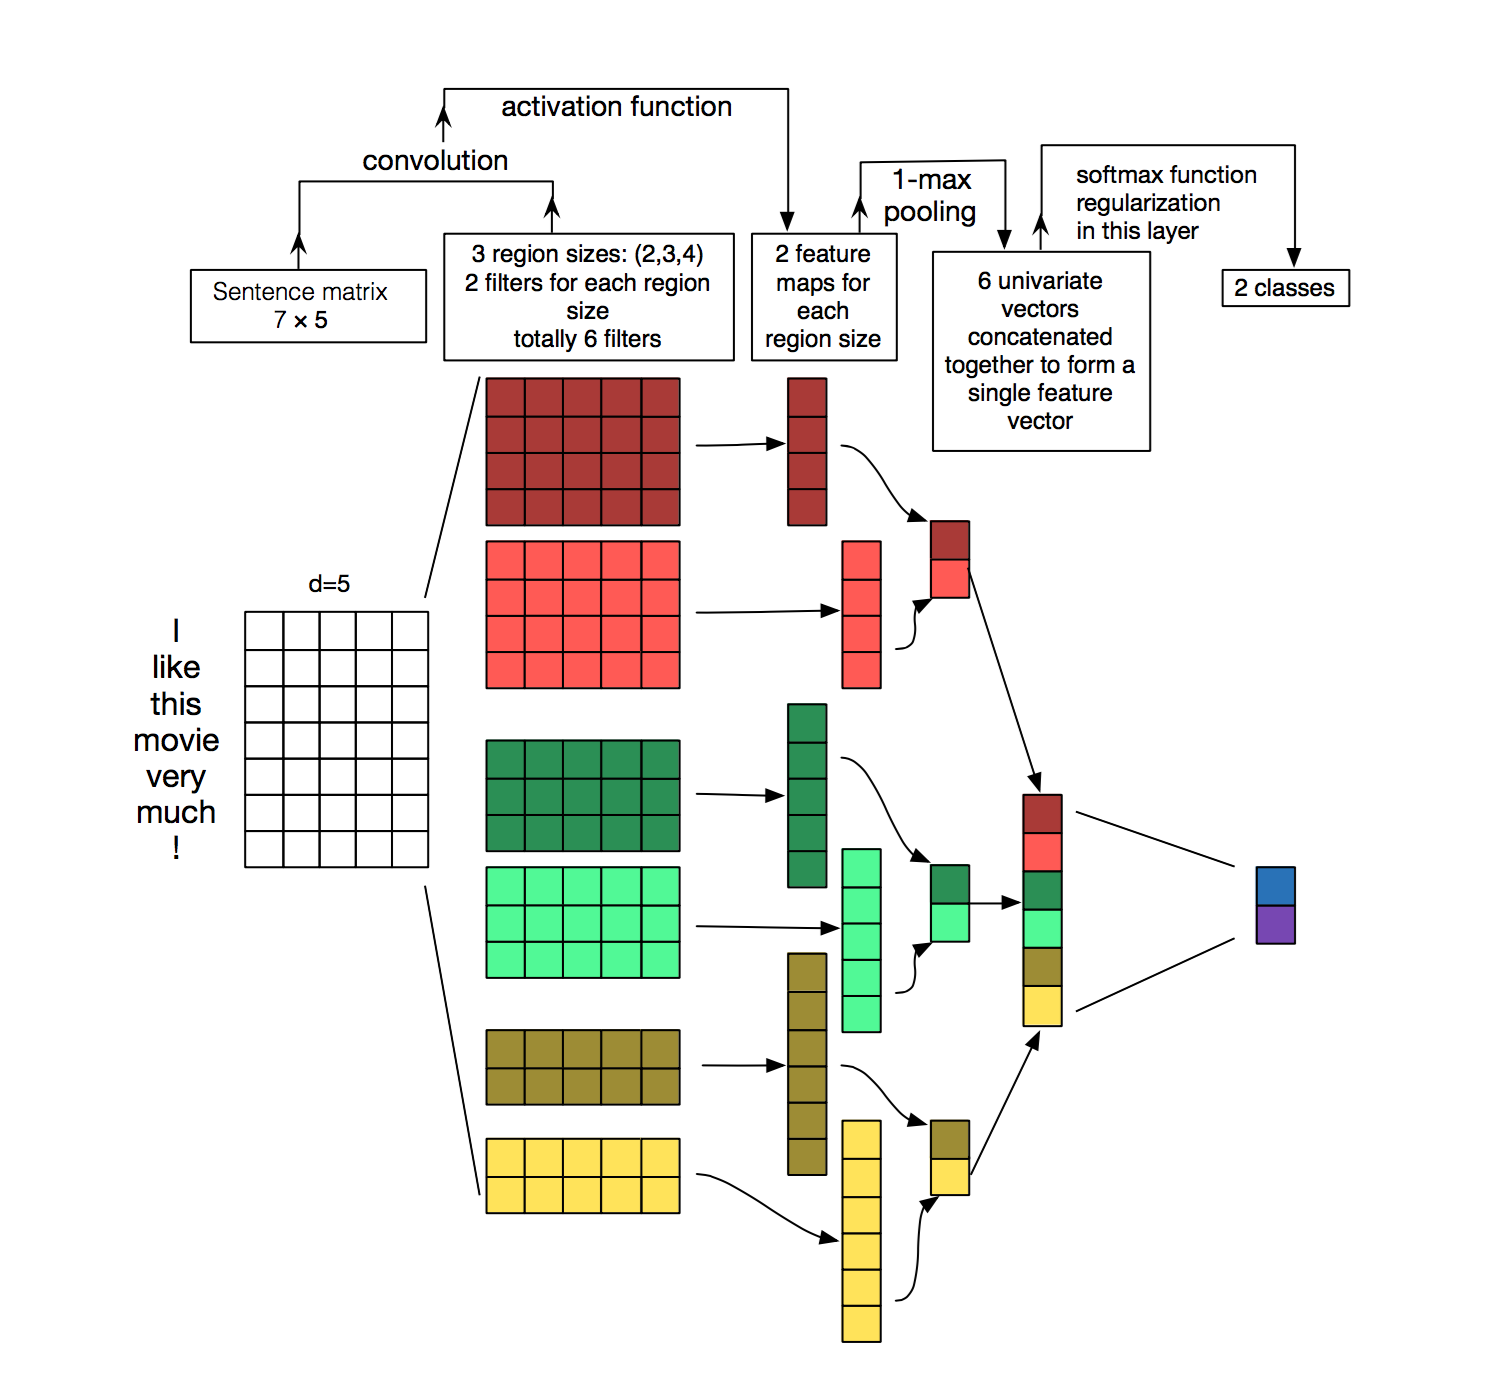

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        """
        super().__init__()

        filter_size = 32
        kernel_size = 5
        stride = 1

        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.padding = nn.ZeroPad2d((stride * (kernel_size - 1), 0, 0, 0)) # left padding
        self.conv_1 = nn.Conv1d(in_channels=emb_size, out_channels=hid_size, kernel_size=kernel_size, stride=stride)
        self.conv_2 = nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=kernel_size, stride=stride)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)


    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        input_ix = torch.as_tensor(input_ix).to(device)
        out = self.embedding(input_ix)
        out = torch.permute(out, (0, 2, 1))
        out = self.conv_1(self.padding(out))
        for _ in range(3):
            out = self.conv_2(self.padding(out))
        out = torch.permute(out, (0, 2, 1))
        out = self.linear(out)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [ ]:
dummy_model = FixedWindowLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embedding.weight', 'conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'linear.weight', 'linear.bias')


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
# test lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

Будем минимизировать categorical crossentropy во время обучения на данных $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

Минимизация categorical crossentropy эквивалентная минимизации перплексии

[Entropy, Perplexity and Its Applications](https://leimao.github.io/blog/Entropy-Perplexity/)

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [ ]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    mask = compute_mask(input_ix)[:, 1:]
    lengths = mask.sum(-1) - 1 # drop padded
    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    answers = torch.nn.functional.one_hot(reference_answers, num_classes=logits.shape[2])
    loss = torch.sum(
        (torch.logsumexp(logits, dim=2) - torch.sum(logits * answers, dim=2)) * mask
    ) / len(lengths)
    return loss

In [ ]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

#### Оценка качества


In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

#### Training loop


In [ ]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_test_every = 250
train_history, test_history = [], []
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

test_history.append((0, score_lines(model, test_lines, batch_size)))
print("Sample before training:", generate(model, 'NLP is a '))

Sample before training: NLP is a öHãá°9(öΣÖH:+S?}\iÉ?+%GI|FMΠÖRtőMpâszdPσhö""_vcx5{z8Büç{!τUB64Ł^|fσ;YΣr()Ci$QF@Gên={kωuè8bz


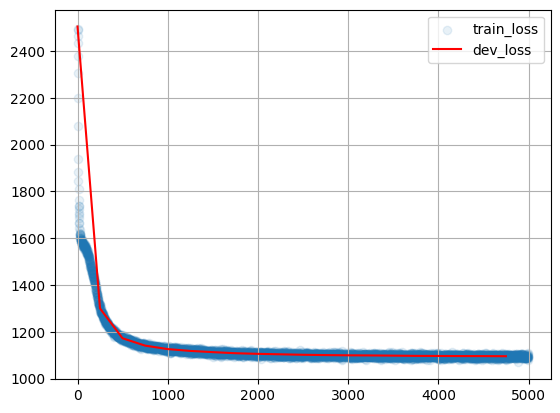

Generated examples (tau=0.5):
 Anting tor Ralusion and ancomed te thation the sertien the deat se the toriceare for the red as ane 
 Conte Ving the arale tho mpesting in this propres no s and and tionel trectimen proplestin te roche 
 The seatin tof cuptoras in works we d are tre anditit  ha detter coprobling ang mathe probe mone sul
Scoring test...


100%|██████████| 5000/5000 [05:25<00:00, 15.36it/s]

#4999 Test loss: 1094.769


In [ ]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(test_history):
            plt.plot(*zip(*test_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_test_every == 0:
        print("Scoring test...")
        test_history.append((i, score_lines(model, test_lines, batch_size)))
        print('#%i Test loss: %.3f' % test_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", test_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1094.768515625
 A Sulacization ; In ser corper, whe dect pecente teon the serncestro s medition th thens and the sem
 Ancomed ta nomplesing apprexcentis in the ratimize d andero te thes ante for coproble for tictale an
 Seat ing Incon the lowith th aus inalge retrimenon deca cons te the he probitit  of lapereant of ins
 Antor Inverian ap Netwerks anderative ; We prorest an wered to the tistis arfict on tumentis co nom 
 Tha beaplons ancons ta n aresing atar ander andicions ther wever onverouse aptive ender ing and cons
 Mation the deat wo des of the orag sere the se the proformang the proved for the pation te tereall a
 A torale rowivis aree seingrats tate forianing of cheve the the antovition that expetsing aperal tat
 Modind SAStons ; An lave tion tha se pored tathe rabling tor Conste and andimation lation ing inatio
 Suctive antinge of emation prealing ingucentore sedel sed antien vel chered tith inated the s are th
 A Fintrat ing ande terotre sempation to she gote t

In [ ]:
print(generate(model, prefix='NLP is a ', temperature=0.5))

NLP is a Sual Sy pesting an the leared to the Reasit the co purecand al worivition and malition thoin


### RNN LM

Попробуем использовать RNN для LM:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$


Модель обрабатывает по одному токену слева направо, поддерживая скрытое состояние, выучиваемое из токенов

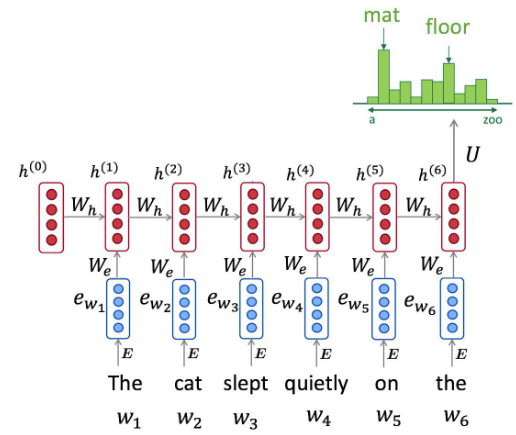

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
        """
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)

    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        input_ix = torch.as_tensor(input_ix).to(device)
        out = self.embedding(input_ix)
        out, (hn, cn) = self.lstm(out)
        out = self.linear(out)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [ ]:
model = RNNLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embedding.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'linear.weight', 'linear.bias')


In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

#### RNN training


In [ ]:
batch_size = 64
score_dev_every = 250
clip_value = 5
train_history, test_history = [], []
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

test_history.append((0, score_lines(model, test_lines, batch_size)))
print("Sample before training:", generate(model, 'NLP is a '))

Sample before training: NLP is a ωÜmβ-NõâBY0W]äB\őôê?τFmèANUÖ



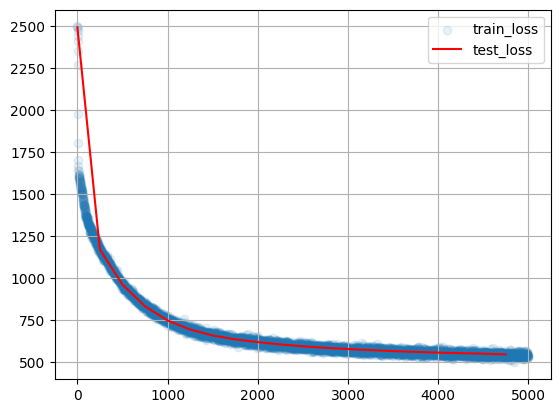

Generated examples (tau=0.5):
 Deep Convolutional Neural Networks for Sparse Models ; A multi-information algorithm in developing t
 The Study for Semi-Supervised Activity Recognition ; We propose a new convolutional neural network a
 Texture Deep Convolutional Neural Networks ; We propose a new sparse recognition of the basis of thi
Scoring test...


100%|██████████| 5000/5000 [05:51<00:00, 14.24it/s]

#4999 Test loss: 542.335


In [ ]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(test_history):
            plt.plot(*zip(*test_history), color='red', label='test_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring test...")
        test_history.append((i, score_lines(model, test_lines, batch_size)))
        print('#%i Test loss: %.3f' % test_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", test_history[-1][-1])
for i in range(10):
    print(generate(model, prefix='NLP is a ', temperature=0.5))

Final dev loss: 542.3349716558689
NLP is a Recurrent Neural Network for Deep Learning ; This paper presents a novel manifold of non-con
NLP is a serve-training the learning of flexible applications ; We propose a novel constraint of the 
NLP is a Biological Structure for Interactive Analysis of Tree ; We propose a new approach for a prob
NLP is a Bayesian Detection of Optimization of Face Selection ; The deep learning from different and 
NLP is a novel approach to the translation of learning approaches ; In this paper, we propose a novel
NLP is a method for active solutions to supervised learning ; This paper presents a novel approach to
NLP is a set of output and a set of learning and tree ; Interpretation of predictive sampling and ana
NLP is a multi-similarity of the Interpretation of Learning Matrix   Autoencoder ; We present a formu
NLP is a computational computational results on convolutional   solving the image model for understan
NLP is a generation of a given data retrieval fo

### Стратегии сэмплирования

До сих пор мы сэплировали токены в соответствии с их вероятностями, однако здесь могут возникнуть проблемы, связанные с тем что softmax по определению не выдает нулевые вероятностии, и мы можем получить бессмысленные токены в ответе.

Температура отчасти решает эту проблему, но низкая температура вредит разнообразию генерации. Попробуем рассмотреть другую стратегию сэмплирования -  __top-k sampling:__ на каждом шаге сэмплируем следующий токен из топ k наиболее вероятных кандидатов.



#### **Nucleus Sampling (ядерное сэмплирование)**

похожая идея на топ-k сэмплирование, но $k$ теперь выбирается динамически. В ядерном сэмплировании мы сэмплируем из top-__N%__ вероятностного распределения.

Например, при вероятностях токенов $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ и N=0.89, сэмплированные токены выглядят как:
1. наиболее вероятный токен $w_2$, так как $p(w_2) < N$
2. второй наиболее вероятный токен $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. третий наиболее вероятный токен $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

И на этом все, так как добавление любого следующего токена переполнит возможное предельное значение (N): $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

После выбора токенов ядерным сэмплированием, необходимо нормализовать их и сэмплировать следующий токен


In [ ]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus  always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)
        probs_sort = (-1 * probs).argsort()

        count = 0
        tokens_ids = []
        while nucleus >= 0:
            tokens_ids.append(probs_sort[count])
            nucleus -= probs[probs_sort[count]]
            count += 1
        probs[tokens_ids] = 0
        probs /= sum(probs)
        next_token = np.random.choice(tokens, p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
for n in np.linspace(0.1, 0.9, 9):
    print(f"nucleus value: {np.round(n, 2)}, text: {generate_nucleus(model, prefix='NLP is a ', nucleus=n)}")

nucleus value: 0.1, text: NLP is a challenging task learning for learning the reinforcement learning with learning Kerne Cluste
nucleus value: 0.2, text: NLP is a Hitraching-First Learning of the Distributional   trowsed Structures for Non-Opposing Detect
nucleus value: 0.3, text: NLP is a one different problem for mobile coordinal efficients ; Recommender knowledge in po-find obt
nucleus value: 0.4, text: NLP is a New Checking CPhEB O(mention ; Treedic Tree Semantics (NP-CKN)), application of dimensionali
nucleus value: 0.5, text: NLP is a Deep Neural Networks with Visualities: Onorward Properties in the Problem -   to enable anal
nucleus value: 0.6, text: NLP is a Video-Gack-Recognition Task on IpLayfy developed Representations ; In this paper we sever up
nucleus value: 0.7, text: NLP is a be for V-stanting from a Upy Spented Can Reconstruction, Mocate   Training ; In this paper, 
nucleus value: 0.8, text: NLP is a Tensoring and Segmentation for Videos for Minitar Machine (THI Kock A

#### Beam Search (лучевой поиск)

Иногда нам не нужно, чтобы модель генерировала разнообразные результаты, так как вмы хотим получить один лучший вариант с учетом префикса.

Чтобы найти наиболее вероятную последовательность, содержащую 10 токенов,  нужно будет проверить все $|V|^{10}$ возможных гипотез. Однако можно найти приблизительный наиболее вероятный результат с помощью **beam search**.

Как это работает:
0. Инициализируем `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` генерируем все возможные токены для всех гипотез в beam, `len(beam) * len(vocab)` кандидатов
3. ` ... ` выбираем `beam_size` лучших кандидатов как новый `beam`
4. Выбираем лучшую гипотезу из beam

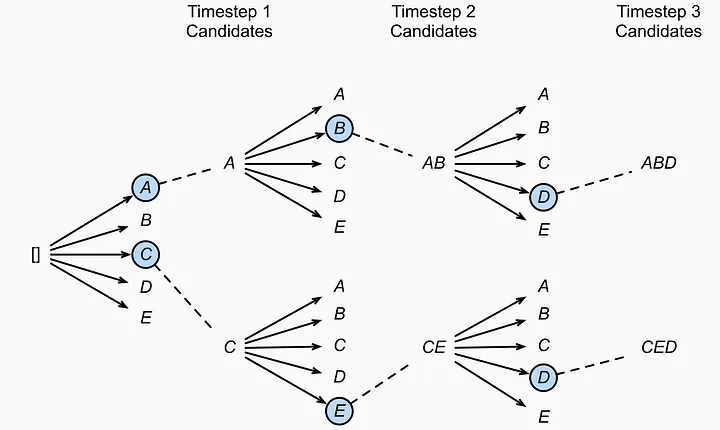

[PyTorch Beam Search](https://github.com/jarobyte91/pytorch_beam_search) - PyTorch implementation of beam search decoding for seq2seq models